<h1>World Series Prediction</h1>
<h1 style="color:red;">THIS PROJECT IS NOT A BETTING ADVICE.</h1>
<p></p>
<div>
    <b>Who will win the World Series</b>?
    Let's find out.
</div>

<h2>Table of Contents</h2>
<ol>
    <li><a href="#1">Import the data into DataFrame</a></li>
    <li><a href="#2">Process the Data</a></li>
    <li><a href="#3">Training the Model</a></li>
    <li><a href="#4">Conclusion</a></li>
</ol>

<p>Let's first import essential packages.</p>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

<h2 id="1">1. Import the data into DataFrame</h2>
<p></p>
<div>
    <p>This data is from <a href="https://www.kaggle.com/open-source-sports/baseball-databank">Baseball Databank</a> from Kaggle.</p>
</div>


In [2]:
teams = pd.read_csv("../data/baseball/Teams.csv")
teams #verifying

yearID lgID teamID franchID divID  Rank    G  Ghome   W   L  ...     DP  \
0       1871  NaN    BS1      BNA   NaN     3   31    NaN  20  10  ...    NaN   
1       1871  NaN    CH1      CNA   NaN     2   28    NaN  19   9  ...    NaN   
2       1871  NaN    CL1      CFC   NaN     8   29    NaN  10  19  ...    NaN   
3       1871  NaN    FW1      KEK   NaN     7   19    NaN   7  12  ...    NaN   
4       1871  NaN    NY2      NNA   NaN     5   33    NaN  16  17  ...    NaN   
...      ...  ...    ...      ...   ...   ...  ...    ...  ..  ..  ...    ...   
2800    2015   NL    LAN      LAD     W     1  162   81.0  92  70  ...  133.0   
2801    2015   NL    SFN      SFG     W     2  162   81.0  84  78  ...  145.0   
2802    2015   NL    ARI      ARI     W     3  162   81.0  79  83  ...  146.0   
2803    2015   NL    SDN      SDP     W     4  162   81.0  74  88  ...  138.0   
2804    2015   NL    COL      COL     W     5  162   81.0  68  94  ...  171.0   

         FP                     name                          park  \
0     0.830     Boston Red Stockings           South End Grounds I   
1     0.820  Chicago White Stockings       Union Base-Ball Grounds   
2     0.810   Cleveland Forest Citys  National Association Grounds   
3     0.800     Fort Wayne Kekiongas                Hamilton Field   
4     0.830         New York Mutuals      Union Grounds (Brooklyn)   
...     ...                      ...                           ...   
2800  0.988      Los Angeles Dodgers                Dodger Stadium   
2801  0.987     San Francisco Giants                     AT&T Park   
2802  0.986     Arizona Diamondbacks                   Chase Field   
2803  0.985         San Diego Padres                    Petco Park   
2804  0.985         Colorado Rockies                   Coors Field   

      attendance  BPF  PPF  teamIDBR  teamIDlahman45  teamIDretro  
0            NaN  103   98       BOS             BS1          BS1  
1            NaN  104  102       CHI             CH1          CH1  
2            NaN   96  100       CLE             CL1          CL1  
3            NaN  101  107       KEK             FW1          FW1  
4            NaN   90   88       NYU             NY2          NY2  
...          ...  ...  ...       ...             ...          ...  
2800   3764815.0  101   98       LAD             LAN          LAN  
2801   3375882.0   99   97       SFG             SFN          SFN  
2802   2080145.0  107  106       ARI             ARI          ARI  
2803   2459742.0   98   97       SDP             SDN          SDN  
2804   2506789.0  119  118       COL             COL          COL  

[2805 rows x 48 columns]

<h2 id="2">2. Process the Data</h2>
<p>There has been many changes made since Major League Baseball was created.</p>
<div>
    <p>
        For <b>consistency in rules</b>, I chose to include <b>only live-ball era(1920~) records</b>.
    </p>
    <p>
        For <b>changes in the total game played</b>, I have turned <b>games won</b> into <b>fraction of games won over the total games played</b>.
    </p>
    <p>
        For <b>change in the number of teams and proficiency of pitching and batting</b>, I have changed <b>stats into percentiles</b> relative to <b>performance of other teams in the corresponding season</b>.
    </p>
</div>

In [3]:
from scipy.stats import percentileofscore as score

"""
    Both teams that made to the World Series has won the league(AL/NL). However,
    one difference is World Series Win.
"""

teams['GamesWon'] = (teams['W'] / teams['G']).round(3)
WSdata = teams[
    (teams['yearID'] >= 1920) & 
    ((teams["WSWin"] == "Y") | ((teams["WSWin"] == "N") & (teams["LgWin"] == "Y")))
]

features = [
    'R',      #Run
    'AB',     #At Bat
    'H',      #Hit
    '2B',     #Double
    '3B',     #Triple
    'HR',     #Homerun
    'BB',     #Base on Balls
    'SO',     #Strike out
    'SB',     #Stolen Bases
    'CS',     #Caught Stealing
    'HBP',    #Hit by a Pitch
    'SF',     #Sacrifice Fly
    'RA',     #Pitcher'sRun Average
    'ER',     #Earned Run
    'ERA',    #Earned Run Average
    'CG',     #Complete Game
    'SHO',    #Shutout
    'SV',     #Save
    'IPouts', #
    'HA',     #
    'HRA',    #
    'BBA',    #
    'SOA',    #
    'E',      #Error
    'DP',     #
    'FP',     #
    'BPF',    #Ball Park Factor 
    'PPF'     #
]

feature_percentile_col = lambda feature : f"{feature} Percentile"
percentiles = {feature_percentile_col(feature) : [] for feature in features}
for row in WSdata.index:
    yearID = WSdata.loc[row, 'yearID']
    target_year_teams = teams[teams['yearID'] == yearID]
    for feature in features:
        percentiles[feature_percentile_col(feature)].append(
            round(
                score(target_year_teams[feature], WSdata.loc[row, feature]),
                3
            )
        )

for column, series in percentiles.items():
    WSdata[column] = series

features = list(percentiles.keys())
final_features = ['yearID', 'name', 'GamesWon', 'WSWin'] + features
WSdata = WSdata[final_features].set_index("yearID")

/var/folders/67/9r4fydw50cgd28p70wdc2klh0000gn/T/ipykernel_56768/1148850318.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WSdata[column] = series


In [4]:
WSdata

name  GamesWon WSWin  R Percentile  AB Percentile  \
yearID                                                                      
1920         Brooklyn Robins     0.600     N        56.250         93.750   
1920       Cleveland Indians     0.636     Y       100.000         31.250   
1921         New York Giants     0.614     Y        81.250         31.250   
1921        New York Yankees     0.641     N       100.000         18.750   
1922         New York Giants     0.596     Y        81.250         87.500   
...                      ...       ...   ...           ...            ...   
2013     St. Louis Cardinals     0.599     N        93.333         63.333   
2014      Kansas City Royals     0.549     N        56.667         61.667   
2014    San Francisco Giants     0.543     Y        63.333         43.333   
2015      Kansas City Royals     0.586     Y        80.000         83.333   
2015           New York Mets     0.556     N        46.667         56.667   

        H Percentile  2B Percentile  3B Percentile  HR Percentile  \
yearID                                                              
1920          68.750         25.000        100.000         31.250   
1920          84.375        100.000         81.250         56.250   
1921          68.750         37.500         62.500         75.000   
1921          75.000         93.750         43.750        100.000   
1922          87.500         75.000         81.250         68.750   
...              ...            ...            ...            ...   
2013          90.000         96.667         28.333         13.333   
2014          86.667         80.000         60.000          3.333   
2014          66.667         33.333         96.667         46.667   
2015          96.667         93.333         83.333         23.333   
2015          20.000         90.000          8.333         75.000   

        BB Percentile  ...  IPouts Percentile  HA Percentile  HRA Percentile  \
yearID                 ...                                                     
1920           18.750  ...            100.000         18.750           9.375   
1920          100.000  ...             18.750         37.500          31.250   
1921           81.250  ...             56.250         31.250          90.625   
1921           93.750  ...             34.375         12.500          34.375   
1922           50.000  ...             87.500         18.750          65.625   
...               ...  ...                ...            ...             ...   
2013           56.667  ...             70.000         33.333           6.667   
2014            3.333  ...             40.000         51.667          31.667   
2014           33.333  ...             36.667         20.000          36.667   
2015            6.667  ...             66.667         43.333          31.667   
2015           66.667  ...             86.667         20.000          26.667   

        BBA Percentile  SOA Percentile  E Percentile  DP Percentile  \
yearID                                                                
1920            18.750         100.000        56.250         25.000   
1920            37.500          62.500        12.500         43.750   
1921             6.250          12.500        25.000         96.875   
1921            75.000          93.750        62.500         56.250   
1922            18.750          31.250        31.250         68.750   
...                ...             ...           ...            ...   
2013            20.000          66.667        15.000         96.667   
2014            26.667          20.000        71.667         13.333   
2014             6.667          33.333        51.667         83.333   
2015            68.333          30.000        36.667         41.667   
2015             6.667          70.000        36.667         20.000   

        FP Percentile  BPF Percentile  PPF Percentile  
yearID                                                 
1920           43.750          90.625          

<p>Let's check if there is any missing data</p>

In [5]:
WSdata.isnull().sum()

name                   0
GamesWon               0
WSWin                  0
R Percentile           0
AB Percentile          0
H Percentile           0
2B Percentile          0
3B Percentile          0
HR Percentile          0
BB Percentile          0
SO Percentile          0
SB Percentile          0
CS Percentile         25
HBP Percentile       158
SF Percentile        158
RA Percentile          0
ER Percentile          0
ERA Percentile         0
CG Percentile          0
SHO Percentile         0
SV Percentile          0
IPouts Percentile      0
HA Percentile          0
HRA Percentile         0
BBA Percentile         0
SOA Percentile         0
E Percentile           0
DP Percentile          0
FP Percentile          0
BPF Percentile         0
PPF Percentile         0
dtype: int64

This time, We will drop column(s) with missing data.

In [6]:
features_to_remove = ['CS Percentile', 'HBP Percentile', 'SF Percentile']
WSdata = WSdata.drop(features_to_remove, axis = 1)

for feature in features_to_remove:
    features.remove(feature)

<h2>3. Training the Model</h2>
<p>Since it is a <b>classification problem</b>, I have trained and compare two models using <b>Logistic Regression</b> and <b>Decision Tree</b>.</p>

In [7]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
features = ['GamesWon'] + features
target = "WSWin"
WSdata[target] = [1 if val == "Y" else 0 for val in WSdata[target].values] #for Logistic Regression

X, y = WSdata[features], WSdata[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False) #it is time-series data.

<h3>Logistic Regression</h3>

In [8]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Let's evaluate the performance of Logistic Regression model using <b>Confusion Matrix</b>.

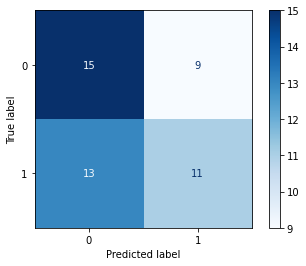

In [9]:
plot_confusion_matrix(
    model,                 #model
    X_test,                #X values
    y_test,                #y values
    cmap = plt.cm.Blues    #styling
)
plt.show()

<div>
    <ul>
        <li><b>0</b> means <b>Losing</b></li>
        <li><b>1</b> means <b>Winning</b></li>
    </ul>
    <p>
        On the X-axis, it represents actual datapoint result. On the Y-axis, it represents the predicted datapoint results.
    </p>
    <ul>
        <li>If <b>both True label and Predicted Label is 1</b>, it is <b>correct prediction</b> for winning.</li>
        <li>If <b>True label is 1 and Predicted Label is 0</b>, it is <b>incorrect prediction</b> for winning.</li>
        <li>If <b>True label is 0 and Predicted Label is 1</b>, it is <b>incorrect prediction</b> for losing.</li>
        <li>If <b>both True label and Predicted Label is 0</b>, it is <b>correct prediction</b> for losing.</li>
    </ul>
</div>

<div>
    <p>We are interested in correct predictions. We can compute our accuracy.</p>
</div>

In [10]:
y_preds = model.predict(X_test)

LR_accuracy = (accuracy_score(y_preds, y_test) * 100).round(2)
print(f"Accuracy of Logistic Regression is {LR_accuracy}%.")

Accuracy of Logistic Regression is 54.17%.


<h3>Decision Tree</h3>
<p>Let's first pre-prun the decision tree by finding optimal parameters because <b>decision tree tends to overfit</b>.</p>

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt = DecisionTreeClassifier()
parameter_grid =  {
    'max_depth': [5, 15, 25, 50],
    'min_samples_leaf': [i for i in range(1, int(math.sqrt(len(features))))],
    'max_leaf_nodes': [10, 20, 35, 50, 100]
}
gs = GridSearchCV(
    dt,                          
    parameter_grid,                #parameter grid(give options to try here)
    cv = 5                         #how many folds for k-fold method
)
gs.fit(X_train, y_train)           
best_params = gs.best_params_      #get the best parameters.
best_params

{'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}

<p>Now we have best parameters. We can build our optimized decision tree and evaluate its performance.</p>

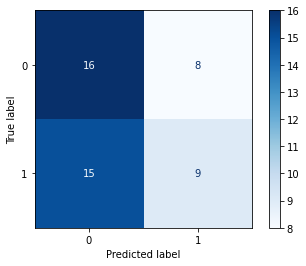

In [12]:
pre_pruned_tree_model = DecisionTreeClassifier(
    max_depth = best_params['max_depth'],   
    min_samples_leaf = best_params['min_samples_leaf'],
    max_leaf_nodes = best_params['max_leaf_nodes']
)
pre_pruned_tree_model.fit(X_train, y_train)

plot_confusion_matrix(
    pre_pruned_tree_model,                
    X_test,                #X values
    y_test,                #y values
    cmap = plt.cm.Blues    #styling
)
plt.show()

<div>
    <p>Please refer <a>here</a> to read confusion matrix.
        We are interested in correct predictions. We can compute our accuracy.</p>
</div>

In [13]:
y_preds = pre_pruned_tree_model.predict(X_test)

DT_accuracy = (accuracy_score(y_preds, y_test) * 100).round(2)
print(f"Accuracy of Decision Tree is {DT_accuracy }%.")

Accuracy of Decision Tree is 52.08%.


<p>For better understanding, let's visualize the decision tree we just built.</p>

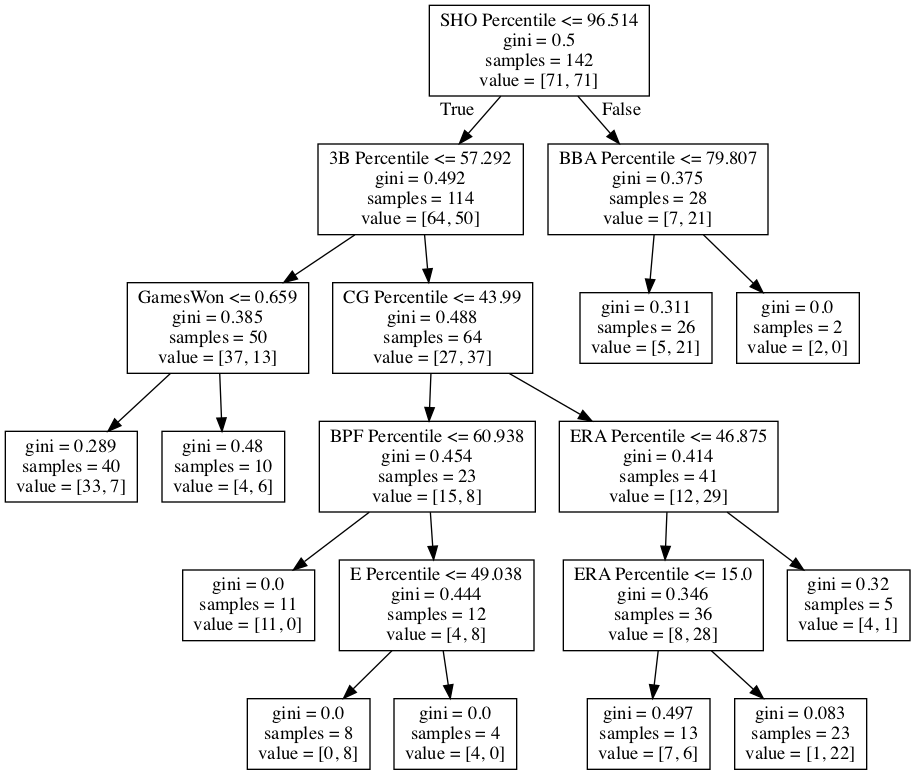

In [14]:
from IPython.display import Image
import graphviz 

dot_file = export_graphviz(pre_pruned_tree_model, feature_names = features)
graph = graphviz.Source(dot_file)
graph.render(
    filename = 'pre_pruned_tree',
    format = 'png',
    cleanup = True
)

Image(filename='pre_pruned_tree.png')

<h2 id="4">Conclusion</h2>

In [19]:
if DT_accuracy > LR_accuracy:
    print(f"Decision Tree performs better with {DT_accuracy}%.")
elif DT_accuracy < LR_accuracy:
    print(f"Logistic Regression performs better with {LR_accuracy}%.")
else:
    print(f"Both performs equally with {LR_accuracy}%.")

Logistic Regression performs better with 54.17%.
